In [1]:
from datetime import time, datetime

import numpy as np
import torch
# import os
import gzip
import matplotlib.pyplot as plt
import torch.nn.functional as F
from numpy import dtype

from torch import nn
from torch.nn import CrossEntropyLoss
from torch.optim import Optimizer
from torch.utils.data import DataLoader, Dataset
from torchinfo import summary

from torchvision.transforms import v2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
# my project
from module.conf import PROJECT_DIR

# matplotlib.use("QTAgg")
%matplotlib inline

In [2]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0) / 1024 ** 3, 1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0) / 1024 ** 3, 1), 'GB')
    # torch.cuda.is_available()
    # torch.cuda.device_count()
    # torch.cuda.current_device()
    # torch.cuda.device(0)
    # torch.cuda.get_device_name(0)
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
# device = "cpu"
print(f"Using {device} device")

Using device: cpu
Using mps device


Each training and test example is assigned to one of the following labels:
|Label|Description|
|-|-----|
|0|T-shirt/top|
|1|Trouser|
|2|Pullover|
|3|Dress|
|4|Coat|
|5|Sandal|
|6|Shirt|
|7|Sneaker|
|8|Bag|
|9|Ankle boot|

In [3]:
M_LABEL = {0: "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
           5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle boot"}

In [4]:
def load_data(kind: str) -> tuple[np.ndarray, np.ndarray]:
    fashion_mnist_path = "/data/sample/fashion_mnist"
    images_path = "".join([PROJECT_DIR, fashion_mnist_path, f"/{kind}-images-idx3-ubyte.gz"])
    labels_path = "".join([PROJECT_DIR, fashion_mnist_path, f"/{kind}-labels-idx1-ubyte.gz"])
    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8, offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8, offset=16).reshape(len(labels), 28, 28)

    return images, labels

In [5]:
X_train, Y_train = load_data(kind='train')
X_test, Y_test = load_data(kind='t10k')

In [6]:
print("Training data shape:", X_train.shape)
print("Training labels shape:", Y_train.shape)
print("Test data shape:", X_test.shape)
print("Test labels shape:", Y_test.shape)

Training data shape: (60000, 28, 28)
Training labels shape: (60000,)
Test data shape: (10000, 28, 28)
Test labels shape: (10000,)


In [7]:
X_train, X_test = X_train / 255.0, X_test / 255.0

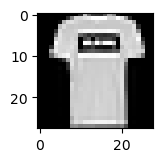

Y_train[1]:0: T-shirt/top


In [8]:
ind = 1
fig, ax = plt.subplots(figsize=(1.5, 1.5))
ax.imshow(X=X_train[ind], cmap="gray")
plt.show()
print(f"Y_train[{ind}]:{Y_train[ind]}: {M_LABEL[Y_train[ind]]}")

### 1. PyTorch

#### 1.1. Define model:

In [9]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(in_features=28 * 28, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=10),
            # nn.Softmax(dim=1)
        )
        return

    def forward(self, x):
        """
        Override forward pass ()
        :param x: x input data 
        :return: 
        """
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
        # return F.log_softmax(logits, dim=1)

In [10]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        # self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        # self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        # self.fc1 = nn.Linear(320, 50)
        # self.fc2 = nn.Linear(50, 10)
        # self.sequence = nn.Sequential(
        #     nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5),   # by default: stride = 1
        #     nn.ReLU(),
        #     nn.MaxPool2d(kernel_size=2),
        #     nn.Conv2d(in_channels=16, out_channels=128, kernel_size=5),
        #     nn.MaxPool2d(kernel_size=2),    # by default: kernel_size = stride 
        #     nn.ReLU(),
        #     nn.Flatten(),
        #     nn.Linear(in_features=2048, out_features=64), # in_features = 2048 will be calculated automatically
        #     nn.Linear(in_features=64, out_features=10),
        #     # nn.LogSoftmax(dim=1), # ~ SparseCategoricalCrossEntropy
        #     nn.LogSigmoid()
        # )
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=5),   # (28-5+1) x (28-5+1) = 24 x 24
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  # (24/2) x (24/2) = 12 x 12
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5),  # (12-5+1) x (12-5+1) = 8 x 8
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)   # (8/2) x (8/2) = 4 x 4
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=128 * 4 * 4, out_features=64),  # 32 channel, 4 * 4 size
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=10)  # 10 classes (0-9) for Fashion MNIST
        )

    def forward(self, x):
        # x = F.relu(F.max_pool2d(self.conv1(x), 2))
        # x = F.relu(F.max_pool2d(self.conv2(x), 2))
        # x = x.view(-1, 320)
        # print(f"--x.shape: {x.shape}")
        # x = F.relu(self.fc1(x))
        # x = self.fc2(x)
        # return F.log_softmax(x, dim=1)
        # return self.sequence(x)
        # return F.log_softmax(x(self.sequence(x)), dim=1)
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

#### 1.2. Define Train and Test functions:

In [11]:
def train(dataloader: DataLoader, model: nn.Module, loss_fn: CrossEntropyLoss, optimizer: Optimizer, epoch: int) -> None:
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device=device), y.to(device=device)
        # reset grad before start new batch
        optimizer.zero_grad()   
        # Compute prediction error
        pred:torch.Tensor = model(X)
        loss:torch.Tensor = loss_fn(pred, y)
        # Backpropagation
        loss.backward()     # calculate the final grad to first grad
        optimizer.step()    # update W and b
        
        if batch % 1000 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"Train loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return

In [12]:
def test(dataloader: DataLoader, model: nn.Module, loss_fn: CrossEntropyLoss) -> None:
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device=device), y.to(device=device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            # pred_probab: torch.Tensor = nn.Softmax(dim=1)(pred)
            pred_probab: torch.Tensor = F.softmax(pred, dim=1)
            correct += (pred_probab.argmax(dim=1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error:\nAccuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}")
    return

#### 1.3. Perform train:

In [13]:
model_nn = NeuralNetwork().to(device)
loss_func_nn = nn.CrossEntropyLoss()
optimizer_g_nn = torch.optim.Adam(params=model_nn.parameters(), lr=1e-3)

In [14]:
model_cnn = CNNModel().to(device)
loss_func_cnn = nn.CrossEntropyLoss()
optimizer_g_cnn = torch.optim.Adam(params=model_cnn.parameters(), lr=1e-3)

In [15]:
rand_seed = np.random.randint(low=0, high=1000)
X_train_20, X_test_20, Y_train_20, Y_test_20 = train_test_split(X_train, Y_train, train_size=0.65, test_size=0.15, random_state=rand_seed)
# Y_train_20 = train_test_split(Y_train, test_size=0.65, random_state=rand_seed)[1]
# rand_seed = np.random.randint(low=0, high=1000)
# X_test_20 = train_test_split(X_train, test_size=0.65, random_state=rand_seed)[1]
# Y_test_20 = train_test_split(Y_train, test_size=0.65, random_state=rand_seed)[1]

In [16]:
class TransformedTensorDataset(Dataset):
    def __init__(self, tensor_dataset, transform=None):
        self.tensor_dataset = tensor_dataset
        self.transform = transform
    def __len__(self):
        return len(self.tensor_dataset)
    def __getitem__(self, idx):
        sample, label = self.tensor_dataset[idx]
        if self.transform:
            sample = self.transform(sample)
            pass
        return sample, label

In [17]:
epochs = 5
batch_size = 32
transform = v2.Compose([
    # v2.ToTensor(),
    # v2.ToPILImage(),
    # v2.PILToTensor(),
    v2.Normalize((0.5,), (0.5,))  # scale from [0, 1] to [-1, 1]
])
X_train_tensor, Y_train_tensor = torch.from_numpy(X_train_20).unsqueeze(dim=1).to(dtype=torch.float32), torch.from_numpy(Y_train_20).to(dtype=torch.int64)
X_test_tensor, Y_test_tensor = torch.from_numpy(X_test_20).float().unsqueeze(dim=1).to(dtype=torch.float32), torch.from_numpy(Y_test_20).to(dtype=torch.int64)
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, Y_train_tensor)
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, Y_test_tensor)
# train_dataset = TransformedTensorDataset(train_dataset, transform=transform)
# test_dataset = TransformedTensorDataset(test_dataset, transform=transform)
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
for t in range(epochs):
    print(f"\nEpoch {t+1}\n-------------------------------")
    start_nn = datetime.now()
    train(train_dataloader, model_nn, loss_func_nn, optimizer_g_nn, t)
    end_nn = datetime.now()
    test(test_dataloader, model_nn, loss_func_nn)
    print(f"NN: {(end_nn - start_nn).total_seconds()}")
    start_cnn = datetime.now()
    train(train_dataloader, model_cnn, loss_func_cnn, optimizer_g_cnn, t)
    end_cnn = datetime.now()
    test(test_dataloader, model_cnn, loss_func_cnn)
    print(f"CNN: {(end_cnn - start_cnn).total_seconds()}")
print("Done!")


Epoch 1
-------------------------------
Train loss: 2.317309  [   32/39000]
Train loss: 0.408308  [32032/39000]
Test Error:
Accuracy: 82.8%, Avg loss: 0.450912
NN: 4.835143
Train loss: 2.304387  [   32/39000]
Train loss: 0.488373  [32032/39000]
Test Error:
Accuracy: 86.7%, Avg loss: 0.365308
CNN: 7.259787

Epoch 2
-------------------------------
Train loss: 0.327711  [   32/39000]
Train loss: 0.283376  [32032/39000]
Test Error:
Accuracy: 86.1%, Avg loss: 0.381558
NN: 4.420655
Train loss: 0.299185  [   32/39000]
Train loss: 0.383480  [32032/39000]
Test Error:
Accuracy: 88.0%, Avg loss: 0.321914
CNN: 7.428578

Epoch 3
-------------------------------
Train loss: 0.363932  [   32/39000]
Train loss: 0.170467  [32032/39000]
Test Error:
Accuracy: 86.6%, Avg loss: 0.354378
NN: 4.291199
Train loss: 0.288113  [   32/39000]
Train loss: 0.118579  [32032/39000]
Test Error:
Accuracy: 89.4%, Avg loss: 0.284549
CNN: 7.190116

Epoch 4
-------------------------------
Train loss: 0.263127  [   32/39000]

In [18]:
summary(model=model_cnn)
# X_train_tensor.shape

Layer (type:depth-idx)                   Param #
CNNModel                                 --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       1,664
│    └─ReLU: 2-2                         --
│    └─MaxPool2d: 2-3                    --
│    └─Conv2d: 2-4                       204,928
│    └─ReLU: 2-5                         --
│    └─MaxPool2d: 2-6                    --
├─Sequential: 1-2                        --
│    └─Flatten: 2-7                      --
│    └─Linear: 2-8                       131,136
│    └─ReLU: 2-9                         --
│    └─Linear: 2-10                      650
Total params: 338,378
Trainable params: 338,378
Non-trainable params: 0

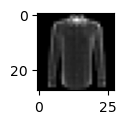

Y_train[1649]:6: Shirt
[1649]:6 NN:6 CNN:6


In [19]:
ind = np.random.randint(low=0, high=10000)
fig, ax = plt.subplots(figsize=(1, 1))
ax.imshow(X=X_test[ind], cmap="gray")
plt.show()

X_test_tensor = torch.from_numpy(X_test[ind]).unsqueeze(0).unsqueeze(0).to(dtype=torch.float32).to(device=device)
with torch.no_grad():
    print(f"Y_train[{ind}]:{Y_test[ind]}: {M_LABEL[Y_test[ind]]}")
    print(f"[{ind}]:{Y_test[ind]} "
        f"NN:{F.softmax(model_nn(X_test_tensor), dim=1).argmax()} "
        f"CNN:{F.softmax(model_cnn(X_test_tensor), dim=1).argmax()}" )

In [20]:
ts = torch.from_numpy(X_test).float()

In [21]:
torch.manual_seed(1729)
r1 = torch.rand(2, 2)
print('A random tensor:')
print(r1)

A random tensor:
tensor([[0.3126, 0.3791],
        [0.3087, 0.0736]])
